In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from matplotlib.image import imread
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Display benign images


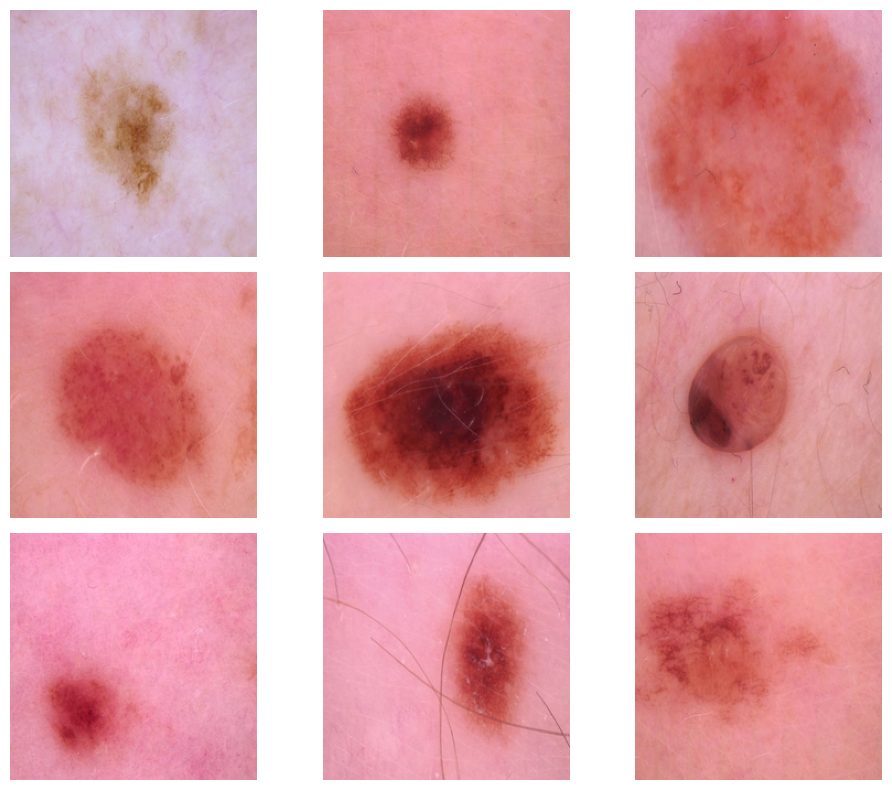

In [2]:
# Define the directory path for the benign images
benign_dir = "./Skin_Lesion/train/benign"

# List all image files in the benign directory
benign_images = [f for f in os.listdir(benign_dir) if os.path.isfile(os.path.join(benign_dir, f))]

# Extract 9 random images from the benign folder
random_images = random.sample(benign_images, 9)  # Randomly select 9 images

# Display the selected benign images
print("Display benign images")

# Adjust the size of the plot
plt.figure(figsize=(10, 8))

# Iterate through and plot the random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(benign_dir, random_images[i])
    img = imread(img_path)  # Load the image
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()

Display malignant images


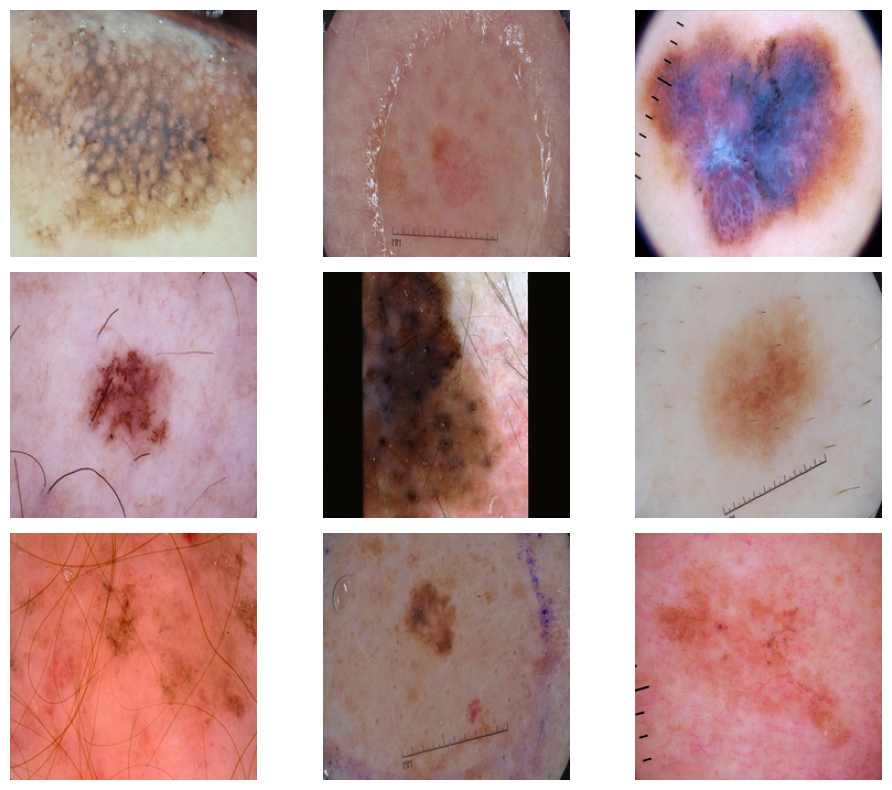

In [3]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Define the directory path for the malignant images
malignant_dir = "./Skin_Lesion/train/malignant"

# List all image files in the malignant directory
malignant_images = [f for f in os.listdir(malignant_dir) if os.path.isfile(os.path.join(malignant_dir, f))]

# Extract 9 random images from the malignant folder
random_images = random.sample(malignant_images, 9)  # Randomly select 9 images

# Display the selected malignant images
print("Display malignant images")

# Adjust the size of the plot
plt.figure(figsize=(10, 8))

# Iterate through and plot the random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(malignant_dir, random_images[i])
    img = imread(img_path)  # Load the image
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image):
    # Step 1: Resize the image to 224x224 pixels
    image = cv2.resize(image, (224, 224))

    # Convert to grayscale for further processing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply Blackhat Filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))  # Adjust kernel size as needed
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)

    # Step 3: Binary Thresholding
    _, binary_thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Step 4: Inpainting
    inpainted_image = cv2.inpaint(image, binary_thresh, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inpainted_image

def custom_preprocessing_function(img):
    # Convert ImageDataGenerator's input (HWC, 0-1 float) to uint8 for OpenCV
    img = (img * 255).astype(np.uint8)

    # Apply the preprocessing steps
    img = preprocess_image(img)

    # Convert back to ImageDataGenerator's expected format (HWC, float 0-1)
    img = img.astype(np.float32) / 255.0
    return img

# Paths
train_dir = './Skin_Lesion/train'
test_dir = './Skin_Lesion/test'

# Image size and batch size
image_size = 224  # Updated size for uniform preprocessing
batch_size = 8

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_function,  # Add the custom preprocessing function
    rotation_range=30,  # Increase rotation range
    width_shift_range=0.3,  # Increase horizontal shift range
    height_shift_range=0.3,  # Increase vertical shift range
    shear_range=0.2,  # Increase shear range
    zoom_range=0.3,  # Increase zoom range
    horizontal_flip=True,  # Enable horizontal flipping
    vertical_flip=True,  # Add vertical flipping
    brightness_range=[0.8, 1.2],  # Vary brightness levels
    fill_mode='reflect',  # Use reflect to create smoother edges
    validation_split=0.1  # Split data into training and validation sets
)

# Test Data Generator (No Augmentation, Only Preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing_function)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),  # Resize all images to 224x224
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (0: benign, 1: malignant)
    subset='training',  # Use 80% of data for training
)

# Validation Data Generator
valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # Use 20% of data for validation
)

# Test Data Generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False  # Disable shuffle for testing to preserve order
)

# Check Class Indices
print("Class indices:", train_generator.class_indices)


Found 2374 images belonging to 2 classes.
Found 263 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Class indices: {'benign': 0, 'malignant': 1}


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Residual Block Definition
def residual_block(x, filters, downsample=False):
    shortcut = x
    stride = 2 if downsample else 1

    # 1x1 Convolution
    x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3x3 Convolution
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Shortcut Connection
    if downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

# ResNet Model Definition
def build_resnet(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Initial Convolution and Pooling
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Stages
    # Stage 1
    for _ in range(3):
        x = residual_block(x, 64)

    # Stage 2
    x = residual_block(x, 128, downsample=True)
    for _ in range(3):
        x = residual_block(x, 128)

    # Stage 3
    x = residual_block(x, 256, downsample=True)
    for _ in range(5):
        x = residual_block(x, 256)

    # Stage 4
    x = residual_block(x, 512, downsample=True)
    for _ in range(2):
        x = residual_block(x, 512)

    # Average Pooling and Fully Connected Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    return Model(inputs, outputs)

# Build the Model
resnet_model = build_resnet()
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint('resnet_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train ResNet
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6677 - loss: 0.9572

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.54753, saving model to resnet_best_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 167s 538ms/step - accuracy: 0.6678 - loss: 0.9562 - val_accuracy: 0.5475 - val_loss: 1.2748
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7201 - loss: 0.5717
Epoch 2: val_accuracy improved from 0.54753 to 0.58175, saving model to resnet_best_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 159s 536ms/step - accuracy: 0.7201 - loss: 0.5716 - val_accuracy: 0.5817 - val_loss: 0.6689
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.7327 - loss: 0.5363
Epoch 3: val_accuracy improved from 0.58175 to 0.65779, saving model to resnet_best_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 163s 549ms/step - accuracy: 0.7327 - loss: 0.5364 - val_accuracy: 0.6578 - val_loss: 0.7017
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7513 - loss: 0.4865
Epoch 4: val_accuracy improved from 0.65779 to 0.73764, saving model to resnet_best_mod

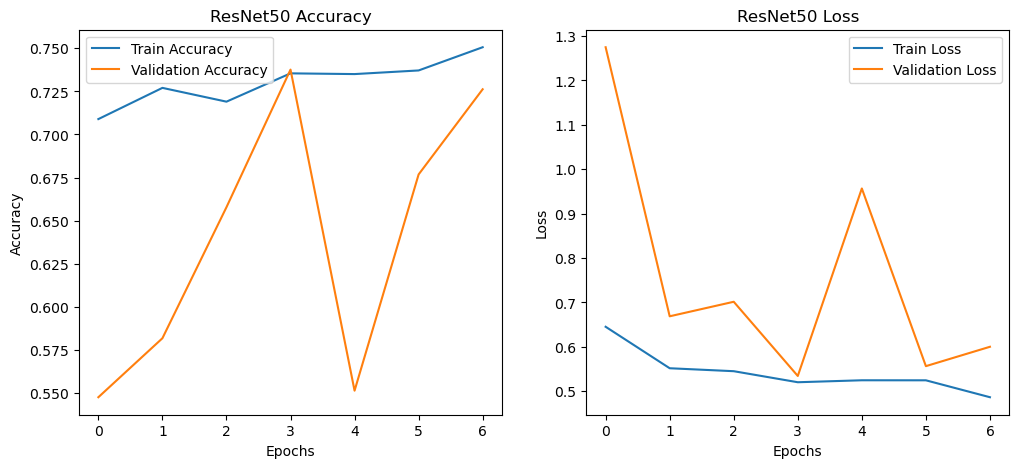

In [6]:
# Plot metrics for ResNet50
def plot_resnet_metrics(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('ResNet50 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('ResNet50 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_resnet_metrics(resnet_history)

In [7]:
# Evaluate ResNet50
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_generator, verbose=1)
print(f"ResNet50 Test Loss: {resnet_test_loss}, Test Accuracy: {resnet_test_accuracy}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.6356 - loss: 0.6810
ResNet50 Test Loss: 0.5365405082702637, Test Accuracy: 0.7681818008422852


83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step


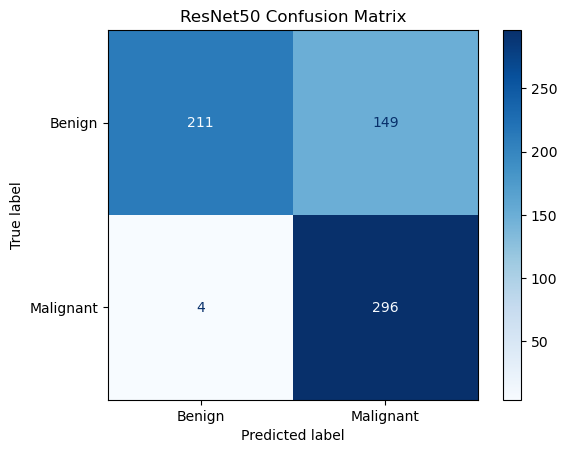

ResNet50 Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.59      0.73       360
   Malignant       0.67      0.99      0.79       300

    accuracy                           0.77       660
   macro avg       0.82      0.79      0.76       660
weighted avg       0.84      0.77      0.76       660



In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Confusion Matrix and Classification Report for ResNet50
def evaluate_resnet_model(model, test_gen):
    y_true = test_gen.classes
    y_pred = (model.predict(test_gen) > 0.5).astype("int32")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('ResNet50 Confusion Matrix')
    plt.show()

    print("ResNet50 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

evaluate_resnet_model(resnet_model, test_generator)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Depthwise Separable Convolution Block
def depthwise_separable_conv_block(x, pointwise_filters, strides=1):
    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', depth_multiplier=1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Pointwise Convolution
    x = Conv2D(pointwise_filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

# MobileNetV2-inspired Model
def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Initial 3x3 Convolution
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise Separable Convolution Layers
    # Stage 1: 32 → 64
    x = depthwise_separable_conv_block(x, 64)

    # Stage 2: 64 → 128
    x = depthwise_separable_conv_block(x, 128, strides=2)
    x = depthwise_separable_conv_block(x, 128)

    # Stage 3: 128 → 256
    x = depthwise_separable_conv_block(x, 256, strides=2)
    x = depthwise_separable_conv_block(x, 256)

    # Stage 4: 256 → 512
    x = depthwise_separable_conv_block(x, 512, strides=2)
    for _ in range(5):  # Repeat 5 times for 5 bottleneck layers
        x = depthwise_separable_conv_block(x, 512)

    # Stage 5: 512 → 1024
    x = depthwise_separable_conv_block(x, 1024, strides=2)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    return Model(inputs, outputs)

# Build the Model
mobilenet_model = build_mobilenetv2()
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint('mobilenet_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train MobileNetV2
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6776 - loss: 0.6590
Epoch 1: val_accuracy improved from -inf to 0.54753, saving model to mobilenet_best_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 94s 299ms/step - accuracy: 0.6777 - loss: 0.6588 - val_accuracy: 0.5475 - val_loss: 1.2294
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7293 - loss: 0.5310
Epoch 2: val_accuracy did not improve from 0.54753
297/297 ━━━━━━━━━━━━━━━━━━━━ 91s 305ms/step - accuracy: 0.7293 - loss: 0.5310 - val_accuracy: 0.5475 - val_loss: 1.4636
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7595 - loss: 0.4908
Epoch 3: val_accuracy improved from 0.54753 to 0.62738, saving model to mobilenet_best_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 89s 299ms/step - accuracy: 0.7595 - loss: 0.4909 - val_accuracy: 0.6274 - val_loss: 0.6956
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7650 - loss: 0.4898
Epoch 4: val_accuracy improved from 0.6273

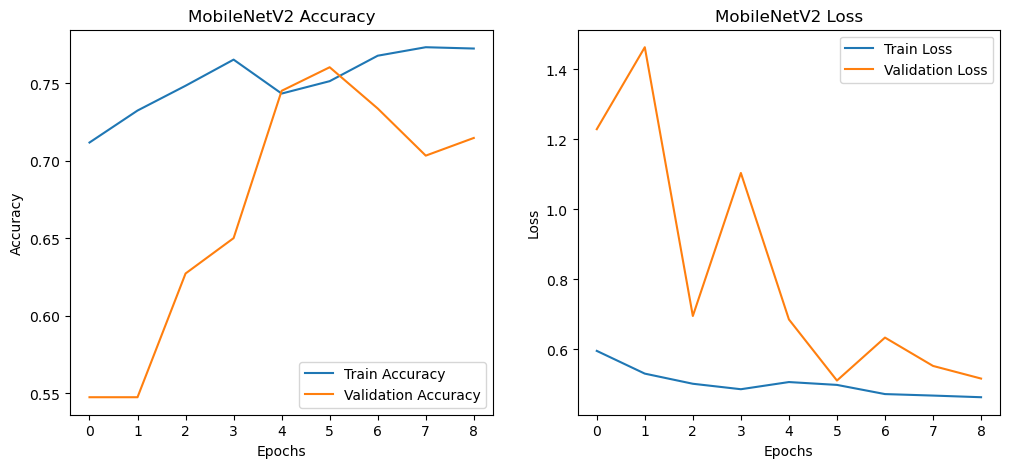

In [11]:
# Plot metrics for MobileNetV2
def plot_mobilenet_metrics(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('MobileNetV2 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MobileNetV2 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_mobilenet_metrics(mobilenet_history)

In [12]:
# Evaluate MobileNetV2
mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(test_generator, verbose=1)
print(f"MobileNetV2 Test Loss: {mobilenet_test_loss}, Test Accuracy: {mobilenet_test_accuracy}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.7872 - loss: 0.4152
MobileNetV2 Test Loss: 0.4837097227573395, Test Accuracy: 0.7560606002807617


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step


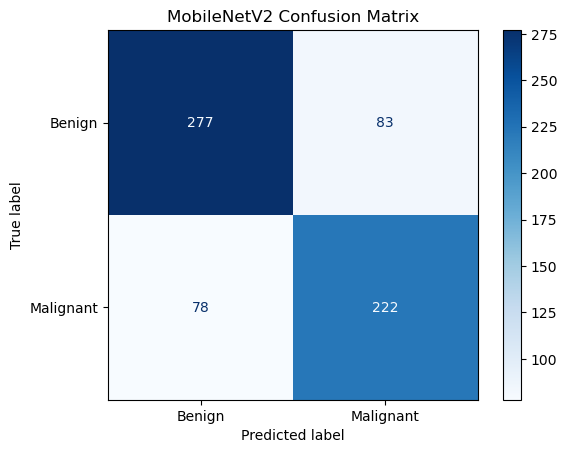

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

      Benign       0.78      0.77      0.77       360
   Malignant       0.73      0.74      0.73       300

    accuracy                           0.76       660
   macro avg       0.75      0.75      0.75       660
weighted avg       0.76      0.76      0.76       660



In [13]:
# Confusion Matrix and Classification Report for MobileNetV2
def evaluate_mobilenet_model(model, test_gen):
    y_true = test_gen.classes
    y_pred = (model.predict(test_gen) > 0.5).astype("int32")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('MobileNetV2 Confusion Matrix')
    plt.show()

    print("MobileNetV2 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

evaluate_mobilenet_model(mobilenet_model, test_generator)